# Chapter 13. Computational Performance

* This chapter will focus on the major factors that affect computational performance: imperative programming, symbolic programming, asynchronous computing, automatic parallelism, and multi-GPU computation.

## Chapter 13.1 Compilers and Interpreters

In [6]:
def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)

    return g

print(fancy_func(1, 2, 3, 4))

10


In [7]:
import torch
from torch import nn
from d2l import torch as d2l

# Factory for networks
def get_net():
    net = nn.Sequential(nn.Linear(512, 256),
                       nn.ReLU(),
                       nn.Linear(256, 128),
                       nn.ReLU(),
                       nn.Linear(128, 2))
    return net

x = torch.randn(size=(1, 512))
net = get_net()
net(x)

tensor([[0.0410, 0.2545]], grad_fn=<AddmmBackward0>)

In [8]:
# By converting the model using torch.jit.script function,
# we are able to compile and optimize the computation in the MLP.

net = torch.jit.script(net)
net(x)

tensor([[0.0410, 0.2545]], grad_fn=<AddmmBackward0>)

In [9]:
# Benchmark to compare with or without jitscript

class Benchmark:
    """For measuring running time."""

    def __init__(self, description='Done'):
        self.description = description

    def __enter__(self):
        self.timer = d2l.Timer()
        return self

    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')


In [10]:
net = get_net()

with Benchmark('Without torchscript'):
    for i in range(3000):
        net(x)

net = torch.jit.script(net)

with Benchmark('With torchscript'):
    for i in range(3000):
        net(x)


Without torchscript: 0.2719 sec
With torchscript: 0.2697 sec


In [ ]:
net.save('my_mlp')
!ls -lh my_mlp*

-rw-r--r--  1 yfzhu  staff   651K Jan 29 11:47 my_mlp


## Chapter 13.2 Asynchronous Computation

In [3]:
# Installation of d2l packages

#!pip install torch==2.0.0 torchvision==0.15.1
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:


In [1]:
import os
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l


In [14]:
# Warmup for GPU computation
device = d2l.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with d2l.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)

with d2l.Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)

numpy: 1.4007 sec
torch: 0.0085 sec


In [16]:
# Another example  to understand the dependency graph.

x = torch.ones((1, 2), device=device)
y = torch.ones((1, 2), device=device)
z = x * y + 2
z

tensor([[3., 3.]], device='cuda:0')

## Chapter 13.3 Automatci Parallelism


In [19]:
devices = d2l.try_all_gpus()

def run(x):
  return [x.mm(x) for _ in range(50)]

x_gpu1 = torch.rand(size=(4000, 4000), device=devices[0])
x_gpu2 = torch.rand(size=(4000, 4000), device=devices[1])

In [21]:
run(x_gpu1)
run(x_gpu2)

torch.cuda.synchronize(devices[0])
torch.cuda.synchronize(devices[1])

with d2l.Benchmark('GPU 1 time'):
  run(x_gpu1)
  torch.cuda.synchronize(devices[0])

with d2l.Benchmark('GPU 2 time'):
  run(x_gpu2)
  torch.cuda.synchronize(devices[1])



GPU 1 time: 1.9003 sec
GPU 2 time: 1.9108 sec


In [22]:
with d2l.Benchmark('GPU1 & GPU2'):
  run(x_gpu1)
  run(x_gpu2)
  torch.cuda.synchronize()



GPU1 & GPU2: 3.6658 sec


In [25]:
def copy_to_cpu(x, non_blocking=False):
  return [y.to('cpu', non_blocking=non_blocking) for y in x]

with d2l.Benchmark('Run on GPU1'):
  y = run(x_gpu1)
  torch.cuda.synchronize()

with d2l.Benchmark('Run on CPU'):
  y_cpu = copy_to_cpu(y)
  torch.cuda.synchronize()

Run on GPU1: 1.9252 sec
Run on CPU: 3.2244 sec


In [26]:
with d2l.Benchmark('Run on GPU1 and copy to CPU'):
  y = run(x_gpu1)
  y_cpu = copy_to_cpu(y, True)
  torch.cuda.synchronize()

Run on GPU1 and copy to CPU: 2.6150 sec


## Chapter 13.4 Hardware

In [28]:
!nvidia-smi

Mon Jan 29 04:48:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              35W /  70W |   6503MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Chapter 13.5 Training on Multiple GPUs

In [3]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [19]:
# A toy network

# Initialize model parameters
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)

params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model

def lenet(X, params):
  h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
  h1_activation = F.relu(h1_conv)
  h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))

  h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
  h2_activation = F.relu(h2_conv)
  h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
  h2 = h2.reshape(h2.shape[0], -1)

  h3_linear = torch.mm(h2, params[4]) + params[5]
  h3 = F.relu(h3_linear)

  y_hat = torch.mm(h3, params[6]) + params[7]

  return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

In [9]:
# Data Synchronization

def get_params(params, device):
  new_params = [p.to(device) for p in params]
  for p in new_params:
    p.requires_grad_()
  return new_params

new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


In [10]:
def allreduce(data):
  for i in range(1, len(data)):
    data[0][:] += data[i].to(data[0].device)
  for i in range(1, len(data)):
    data[i][:] = data[0].to(data[i].device)

data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


In [12]:
# Distributing data

data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=0)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'))


In [13]:
def split_batch(X, y, devices):
  """Split X and y into multiple devices."""
  assert X.shape[0] == y.shape[0]
  return (nn.parallel.scatter(X, devices),
          nn.parallel.scatter(y, devices))



In [17]:
def train_batch(X, y, device_params, devices, lr):
  X_shards, y_shards = split_batch(X, y, devices)

  # Loss is calculated separately on each GPU
  ls = [loss(lenet(X_shard, device_W), y_shard).sum() for X_shard, y_shard, device_W in zip(X_shards, y_shards, device_params)]
  for l in ls:
    l.backward()

  # Sum all gradients from each GPU and broadcast them to all GPUs
  with torch.no_grad():
    for i in range(len(device_params[0])):
      allreduce([device_params[c][i].grad for c in range(len(devices))])

  # The model parameters are updated separately on each GPU
  for param in device_params:
    d2l.sgd(param, lr, X.shape[0])


In [15]:
def train(num_gpus, batch_size, lr):
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
  devices = [d2l.try_gpu(i) for i in range(num_gpus)]

  # Copy model parameters to num_gpus GPUs
  device_params = [get_params(params, d) for d in devices]
  num_epochs = 10
  animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
  timer = d2l.Timer()

  for epoch in range(num_epochs):
    timer.start()
    for X, y in train_iter:
      # Perform multi-GPU training for a single minibatch
      train_batch(X, y, device_params, devices, lr)
      torch.cuda.synchronize()
    timer.stop()

    # Evaluate the modle on GPU 0
    animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
        lambda x: lenet(x, device_params[0]), test_iter, devices[0]), ))

  print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch ' f'on {str(devices)}')


test acc: 0.84, 7.6 sec/epoch on [device(type='cuda', index=0)]


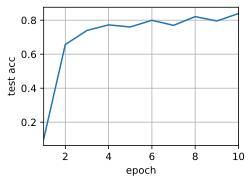

In [20]:
train(num_gpus=1, batch_size=256, lr=0.2)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ValueError: Expected a non cpu device, but got: cpu

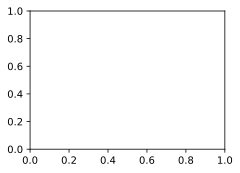

In [21]:
train(num_gpus=2, batch_size=256, lr=0.2)

## Chapter 13.6 Concise Implementation for Multiple GPUs

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

In [25]:
def resnet18(num_classes, in_channels=1):
  """A slightly modified ResNet-18 model."""

  def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        blk.append(d2l.Residual(out_channels, use_1x1conv=True, strides=2))
      else:
        blk.append(d2l.Residual(out_channels))
    return nn.Sequential(*blk)

  # This model uses a smaller convolution kernel, stride, and padding and
  # removes the max-pooling layer
  net = nn.Sequential(
      nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU()
  )

  net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
  net.add_module("resnet_block2", resnet_block(64, 128, 2))
  net.add_module("resnet_block3", resnet_block(128, 256, 2))
  net.add_module("resnet_block4", resnet_block(256, 512, 2))
  net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1, 1)))
  net.add_module("fc", nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))

  return net

In [26]:
net = resnet18(10)

devices = d2l.try_all_gpus()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [29]:
def train(net, num_gpus, batch_size, lr):
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
  devices = [d2l.try_gpu(i) for i in range(num_gpus)]

  def init_weights(module):
    if type(module) in [nn.Linear, nn.Conv2d]:
      nn.init.normal_(module.weight, std=0.01)
  net.apply(init_weights)

  # Set the model on multiple GPUs
  net = nn.DataParallel(net, device_ids=devices)
  trainer = torch.optim.SGD(net.parameters(), lr)
  loss = nn.CrossEntropyLoss()
  timer, num_epochs = d2l.Timer(), 10
  animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])

  for epoch in range(num_epochs):
    net.train()
    timer.start()
    for X, y in train_iter:
      trainer.zero_grad()
      X, y = X.to(devices[0]), y.to(devices[0])
      l = loss(net(X), y)
      l.backward()
      trainer.step()
    timer.stop()
    animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter), ))

  print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch ' f'on {str(devices)}')



test acc: 0.92, 41.8 sec/epoch on [device(type='cuda', index=0)]


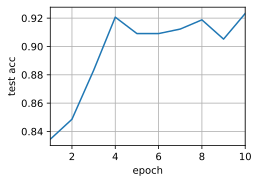

In [30]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

In [ ]:
train(net, num_gpus=2, batch_size=512, lr=0.2)


## Chapter 13.7 Parameter Servers

* Synchronization needs to be highly adaptive to specific network infrastructure and connectivity within a server. This can make a significant difference to the time it takes to synchronize.

* Ring-synchronization can be optimal for p3 and DGX-2 servers. For others possibly not so much.

* A hierarchical synchronization strategy works well when adding multiple parameter servers for increased bandwidth.